# Preparing a proposal

The Story: Suppose that you are preparing to write a proposal on NGC1365, aiming to investigate the intriguing black hole spin this galaxy with Chandra grating observations (see: https://www.space.com/19980-monster-black-hole-spin-discovery.html ) 

In writing proposals, there are often the same tasks that are required: including finding and analyzing previous observations of the proposal, and creating figures that include, e.g., multiwavelength images and spectrum for the source. 


In [2]:
# As a hint, we include the code block for Python modules that you will likely need to import:   
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline  
import requests, io
from astropy.table import Table

## Use NAVO utility for Registry, cone searches and making images and spectra
import sys
from navo_utils.registry import Registry
from navo_utils.image import Image, ImageColumn
from navo_utils.spectra import Spectra, SpectraColumn
from navo_utils.tap import Tap


## There are a number of relatively unimportant warnings that 
## show up, so for now, suppress them:
import warnings
warnings.filterwarnings("ignore")


### Step 1: Find out what the previously quoted Chandra 2-10 keV flux of the central source is for NGC 1365.  

Hint: Do a table access protocol (TAP) search in the heasarc, to find potential table with this information

In [3]:
tap_services=Registry.query(service_type='table',source='heasarc')
url=str(tap_services[0]['access_url'])
# Since there are lots of tables in the HEASARC service, we will narrow the search of Chandra tables by setting contains="chan"
Tap.list_tables(url, contains="chan")

Retrieving tables...
Parsing tables...
Done.
public.bmwchancat
public.chandfn1ms
public.chandfn2ms
public.chandfs1ms
public.chandfs2ms
public.chandfs4ms
public.chandfs7ms
public.chanextdfs
public.changbscat
public.chanmaster
public.channsgpsc
public.chansexagn
public.chansexoid
public.chansexsi
public.chansngcat
public.chantypgpr
public.chanulxcat
public.chanvguide


['public.bmwchancat',
 'public.chandfn1ms',
 'public.chandfn2ms',
 'public.chandfs1ms',
 'public.chandfs2ms',
 'public.chandfs4ms',
 'public.chandfs7ms',
 'public.chanextdfs',
 'public.changbscat',
 'public.chanmaster',
 'public.channsgpsc',
 'public.chansexagn',
 'public.chansexoid',
 'public.chansexsi',
 'public.chansngcat',
 'public.chantypgpr',
 'public.chanulxcat',
 'public.chanvguide']

Hint: The Chansngcat ( https://heasarc.gsfc.nasa.gov/W3Browse/chandra/chansngcat.html ) table is likely the best table.  Create a table with ra, dec, exposure time, and flux (and flux errors) from the public.chansngcat catalog for Chandra observations matched within 0.1 degree.

In [4]:
# list the columns from the query above
Tap.list_columns(url,tablename="public.chansngcat")

TableColumns([('__row', <MaskedColumn name='__row' dtype='int32' length=1>
               1),
              ('source_number',
               <MaskedColumn name='source_number' dtype='int32' length=1>
               286),
              ('name', <MaskedColumn name='name' dtype='str8' length=1>
               NGC 2915),
              ('distance',
               <MaskedColumn name='distance' dtype='float64' format='{!r:>}' length=1>
               4.29),
              ('ra',
               <MaskedColumn name='ra' dtype='float64' format='{!r:>}' length=1>
               141.54804167),
              ('dec',
               <MaskedColumn name='dec' dtype='float64' format='{!r:>}' length=1>
               -76.62633333),
              ('lii',
               <MaskedColumn name='lii' dtype='float64' format='{!r:>}' length=1>
               291.96610299),
              ('bii',
               <MaskedColumn name='bii' dtype='float64' format='{!r:>}' length=1>
               -18.35727285),
           

In [5]:
# Get the coordinate for NGC 1365
import astropy.coordinates as coord
pos=coord.SkyCoord.from_name("ngc1365")

In [6]:
# Show the results from your table query for NGC 1365 and print the ra, dec, exposure time, flux, and flux errors
query="""SELECT ra, dec, exposure, flux, flux_lower, flux_upper FROM public.chansngcat as cat 
    where contains(point('ICRS',cat.ra,cat.dec),circle('ICRS',{},{},0.1))=1 
    and cat.exposure > 0 order by cat.exposure""".format(pos.ra.deg, pos.dec.deg)
results=Tap.query(url,query)
results

ra,dec,exposure,flux,flux_lower,flux_upper
float64,float64,float64,float64,float64,float64
53.40191667,-36.14066667,15500.0,7.751e-12,7.1727e-12,8.2075e-12



### Step 2: Make Images: 

#### Create ultraviolet and X-ray images
Hint: Start by checking what UV image services exist (e.g., GALEX?)

In [7]:
uv_tables=Registry.query(service_type='image',keyword='galex', waveband='uv')
im_gal = uv_tables[np.isin(uv_tables['short_name'], 
                                    ['GALEX'])]
im_gal['short_name', 'access_url']

short_name,access_url
str11,str147
GALEX,https://skyview.gsfc.nasa.gov/cgi-bin/vo/sia.pl?survey=galex&amp;
GALEX,https://mast.stsci.edu/portal/Mashup/VoQuery.asmx/SiaV1?MISSION=GALEX&amp;


Hint: Next create a UV image for the source 

In [8]:
# Do an image search for NGC 1365 in the UV service found above

im_table=Image.query(uv_tables[0],coords=pos,radius=0.1)
im_table[0]

Survey,Ra,Dec,Dim,Size,Scale,Format,PixFlags,URL,LogicalName
str9,float64,float64,int32,object,object,str10,str1,str268,str1
galexnear,53.4019083,-36.1406583,2,[300 300],[-0.0006666666666666668 0.0006666666666666668],image/fits,F,https://skyview.gsfc.nasa.gov/cgi-bin/images?position=53.4019083%2C-36.1406583&survey=galexnear&pixels=300%2C300&sampler=LI&size=0.20000000000000004%2C0.20000000000000004&projection=Tan&coordinates=J2000.0&requestID=skv1544751715380&return=FITS,1
galexnear,53.4019083,-36.1406583,2,[300 300],[-0.0006666666666666668 0.0006666666666666668],image/jpeg,F,https://skyview.gsfc.nasa.gov/cgi-bin/images?position=53.4019083%2C-36.1406583&survey=galexnear&pixels=300%2C300&sampler=LI&size=0.20000000000000004%2C0.20000000000000004&projection=Tan&coordinates=J2000.0&requestID=skv1544751715380&nofits=1&quicklook=jpeg&return=jpeg,1
galexfar,53.4019083,-36.1406583,2,[300 300],[-0.0006666666666666668 0.0006666666666666668],image/fits,F,https://skyview.gsfc.nasa.gov/cgi-bin/images?position=53.4019083%2C-36.1406583&survey=galexfar&pixels=300%2C300&sampler=LI&size=0.20000000000000004%2C0.20000000000000004&projection=Tan&coordinates=J2000.0&requestID=skv1544751715773&return=FITS,2
galexfar,53.4019083,-36.1406583,2,[300 300],[-0.0006666666666666668 0.0006666666666666668],image/jpeg,F,https://skyview.gsfc.nasa.gov/cgi-bin/images?position=53.4019083%2C-36.1406583&survey=galexfar&pixels=300%2C300&sampler=LI&size=0.20000000000000004%2C0.20000000000000004&projection=Tan&coordinates=J2000.0&requestID=skv1544751715773&nofits=1&quicklook=jpeg&return=jpeg,2


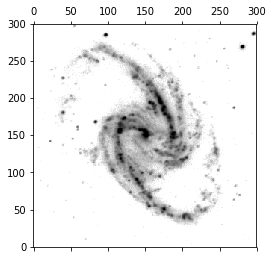

In [9]:
# Get the FITS file (which is index 0 for the NUV image or index=2 for the FUV image)
hdu_list=Image.get_fits(im_table[0][0])
# make an image: 
from pylab import figure, cm
from matplotlib.colors import LogNorm
plt.matshow(hdu_list[0].data, origin='lower', cmap=cm.gray_r, norm=LogNorm(vmin=0.005, vmax=0.3))

Hint: Repeat steps for X-ray image. (Note: Ideally, we would find an image in the Chandra 'cxc' catalog) 

In [10]:
x_tables=Registry.query(service_type='image',waveband='x-ray', source='cxc')
x_tables

waveband,short_name,ivoid,res_description,access_url,reference_url,publisher,service_type
str5,str3,str30,str1799,str43,str27,str25,str17
x-ray,CDA,ivo://cxc.harvard.edu/cda.siap,"The Chandra X-ray Observatory is the U.S. follow-on to the Einstein Observatory. Chandra was formerly known as AXAF, the Advanced X-ray Astrophysics Facility, but renamed by NASA in December, 1998. Originally three instruments and a high-resolution mirror carried in one spacecraft, the project was reworked in 1992 and 1993. The Chandra spacecraft carries a high resolution mirror, two imaging detectors, and two sets of transmission gratings. Important Chandra features are: an order of magnitude improvement in spatial resolution, good sensitivity from 0.1 to 10 keV, and the capability for high spectral resolution observations over most of this range.",http://cda.harvard.edu/cxcsiap/queryImages?,http://cxc.harvard.edu/cda/,Chandra X-ray Observatory,simpleimageaccess
x-ray,CSC,ivo://cxc.harvard.edu/csc.siap,"The Chandra X-ray Observatory is the U.S. follow-on to the Einstein Observatory. Chandra was formerly known as AXAF, the Advanced X-ray Astrophysics Facility, but renamed by NASA in December, 1998. Originally three instruments and a high-resolution mirror carried in one spacecraft, the project was reworked in 1992 and 1993. The Chandra spacecraft carries a high resolution mirror, two imaging detectors, and two sets of transmission gratings. Important Chandra features are: an order of magnitude improvement in spatial resolution, good sensitivity from 0.1 to 10 keV, and the capability for high spectral resolution observations over most of this range. The Chandra Source Catalog (CSC) includes information about X-ray sources detected in observations obtained using the Chandra X-ray Observatory. Release 1.0 of the catalog includes about 95,000 point and compact sources with observed spatial extents less than ~30 arcsec detected in a subset of ACIS imaging observations released publicly prior to the end of 2008. Observed source positions and multi-band count rates are reported, as well as numerous derived spatial, photometric, spectral, and temporal calibrated source properties that may be compared with data obtained by other telescopes. Each record includes the best estimates of the properties of a source based on data extracted from all observations in which the source was detected. The Chandra Source Catalog is extracted from the CXC""s Chandra Data Archive (CDA). The CXC should be acknowledged as the source of Chandra data. For detailed information on the Chandra Observatory and datasets see: http://cxc.harvard.edu/ for general Chandra information; http://cxc.harvard.edu/cda/ for the Chandra Data Archive; http://cxc.harvard.edu/csc/ for Chandra Source Catalog information.",http://cda.harvard.edu/cscsiap/queryImages?,http://cxc.harvard.edu/csc/,Chandra X-ray Observatory,simpleimageaccess


In [11]:
# Do an image search for NGC 1365 in the X-ray CDA service found above
xim_table=Image.query(x_tables[0],coords=pos,radius=0.1)
xim_table[0]

name,instrument,date_obs,ra,dec,naxis,imgscale,imgfmt,accref,filesize,obsid,exptime,bandlo,bandhi,pixflags,institute,Offset,Score
,,d,deg,deg,,degrees/pixel,,,byte,,ks,keV,keV,,,deg,deg
str8,str6,float64,float64,float64,object,object,str10,str137,int32,int32,float64,float64,float64,str1,str3,float64,float64
NGC 1365,ACIS-S,52632.7187273669,53.40963840612605,-36.14743002053731,[1024 1024],[0.0001366666666666667 0.0001366666666666667],image/jpeg,https://cdaftp.cfa.harvard.edu/cgi-bin/chaser_ftp_retrieve_file.cgi?filename=science/ao04/cat7/3554/primary/acisf03554N003_cntr_img2.jpg,230904,3554,14.609389902235,0.2,20.0,C,CXC,4.58653018374082e-05,11.687511921788
NGC 1365,ACIS-S,52632.7187273669,53.40963840612605,-36.14743002053731,[1024 1024],[0.0001366666666666667 0.0001366666666666667],image/fits,https://cdaftp.cfa.harvard.edu/cgi-bin/chaser_ftp_retrieve_file.cgi?filename=science/ao04/cat7/3554/primary/acisf03554N003_cntr_img2.fits,2155680,3554,14.609389902235,0.2,20.0,C,CXC,4.58653018374082e-05,11.687511921788
NGC 1365,ACIS-S,52632.7187273669,53.40963840612605,-36.14743002053731,[1024 1024],[0.001093333333333334 0.001093333333333334],image/jpeg,https://cdaftp.cfa.harvard.edu/cgi-bin/chaser_ftp_retrieve_file.cgi?filename=science/ao04/cat7/3554/primary/acisf03554N003_full_img2.jpg,32096,3554,14.609389902235,0.2,20.0,C,CXC,4.58653018374082e-05,11.687511921788
NGC 1365,ACIS-S,52632.7187273669,53.40963840612605,-36.14743002053731,[1024 1024],[0.001093333333333334 0.001093333333333334],image/fits,https://cdaftp.cfa.harvard.edu/cgi-bin/chaser_ftp_retrieve_file.cgi?filename=science/ao04/cat7/3554/primary/acisf03554N003_full_img2.fits,540000,3554,14.609389902235,0.2,20.0,C,CXC,4.58653018374082e-05,11.687511921788
NGC 1365,ACIS-S,53842.89880481568,53.39919098842813,-36.13960406027974,[1024 1024],[0.0001366666666666667 0.0001366666666666667],image/jpeg,https://cdaftp.cfa.harvard.edu/cgi-bin/chaser_ftp_retrieve_file.cgi?filename=science/ao07/cat7/6868/primary/acisf06868N002_cntr_img2.jpg,94882,6868,14.606446671157999,0.2,20.0,C,CXC,1.1125462078553294e-06,11.6851573369264
NGC 1365,ACIS-S,53842.89880481568,53.39919098842813,-36.13960406027974,[1024 1024],[0.0001366666666666667 0.0001366666666666667],image/fits,https://cdaftp.cfa.harvard.edu/cgi-bin/chaser_ftp_retrieve_file.cgi?filename=science/ao07/cat7/6868/primary/acisf06868N002_cntr_img2.fits,2152800,6868,14.606446671157999,0.2,20.0,C,CXC,1.1125462078553294e-06,11.6851573369264
NGC 1365,ACIS-S,53842.89880481568,53.39919098842813,-36.13960406027974,[1024 1024],[0.001093333333333334 0.001093333333333334],image/jpeg,https://cdaftp.cfa.harvard.edu/cgi-bin/chaser_ftp_retrieve_file.cgi?filename=science/ao07/cat7/6868/primary/acisf06868N002_full_img2.jpg,10194,6868,14.606446671157999,0.2,20.0,C,CXC,1.1125462078553294e-06,11.6851573369264
NGC 1365,ACIS-S,53842.89880481568,53.39919098842813,-36.13960406027974,[1024 1024],[0.001093333333333334 0.001093333333333334],image/fits,https://cdaftp.cfa.harvard.edu/cgi-bin/chaser_ftp_retrieve_file.cgi?filename=science/ao07/cat7/6868/primary/acisf06868N002_full_img2.fits,436320,6868,14.606446671157999,0.2,20.0,C,CXC,1.1125462078553294e-06,11.6851573369264


(460, 560)

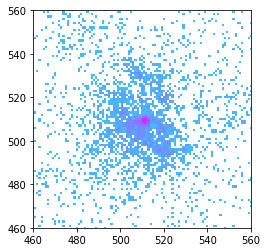

In [12]:
# Create an image from the first FITS file (index=1) by downloading:
xhdu_list=Image.get_fits(xim_table[0][1])

plt.imshow(xhdu_list[0].data, origin='lower', cmap='cool', norm=LogNorm(vmin=0.1, vmax=500.))
plt.xlim(460, 560)
plt.ylim(460, 560)


### Step 3: Make a spectrum: 

#### Find what Chandra spectral observations exist already for this source. 
Hint: try searching for X-ray spectral data tables using the registry query

In [13]:
# Use the TAP protocol to list services that contain X-ray spectral data
services=Registry.query(service_type='spectr',waveband='x-ray')
services

waveband,short_name,ivoid,res_description,access_url,reference_url,publisher,service_type
str56,str14,str49,str678,str71,str58,str36,str20
x-ray,Chandra,ivo://nasa.heasarc/chanmaster,No Description Available,https://heasarc.gsfc.nasa.gov/xamin/vo/ssa?table=chanmaster&amp;,https://heasarc.gsfc.nasa.gov/W3Browse/all/chanmaster.html,NASA/GSFC HEASARC,simplespectralaccess
x-ray#gamma-ray,HEAVENS @ ISDC,ivo://wfau.roe.ac.uk/heavens_at_isdc/light-curves,"With time, all HEAVENS products should become available on the Virtual Observatory. In some cases this requires an enhancement of the Virtual Observatory standards. For now the following HEAVENS services are available through the VO: - SIAP Image cutout service for INTEGRAL/ISGRI and JEM-X - Timeseries service for INTEGRAL/ISGRI, JEM-X and OMC Wished features include: - Extended Query Parameters for time intervals - Extended Query Parameters for energy bands - Timeseries service for INTEGRAL/IREM and SPI-ACS - Spectra service for all INTEGRAL instruments",http://www.isdc.unige.ch/vo-services/lc?,http://www.isdc.unige.ch/heavens/,WFAU,simplespectralaccess
radio#millimeter#infrared#optical#uv#euv#x-ray#gamma-ray,NED/SED,ivo://ned.ipac/sed_data_near_position,"NED SED Information Discovery Request service: The NASA/IPAC Extragalactic Database (NED) provides a comprehensive fusion of multi-wavelength data for hundreds of millions of objects located beyond the Milky Way galaxy. This service retrieves photometry for objects within a specified radius of a given position. The search region is specified by two parameters: POS [RA and DEC in decimal degrees, ICRF/FK5J2000] and SIZE [degrees]. This service returns a list of NED Object Identifiers (Names), the count of photometric SED measurements for each object, and the URI (ACREF) for the SED Data Retrieval request (accessSED). This service is used by the VO SED analysis tool Iris.",http://vo.ned.ipac.caltech.edu/services/querySED?REQUEST=queryData&amp;,http://ned.ipac.caltech.edu/help/data_help.html#ptmydat,The NASA/IPAC Extragalactic Database,simplespectralaccess
gamma-ray#x-ray,INTEGRAL/BSC,ivo://nasa.heasarc/intbsc,No Description Available,https://heasarc.gsfc.nasa.gov/xamin/vo/ssa?table=intbsc&amp;,https://heasarc.gsfc.nasa.gov/W3Browse/all/intbsc.html,NASA/GSFC HEASARC,simplespectralaccess


In [14]:
# We want this last listed service and we can identify this by specifying the short_name
chan_tables = services[np.isin(services['short_name'],['Chandra'])]
chan_tables['short_name', 'access_url']

short_name,access_url
str14,str71
Chandra,https://heasarc.gsfc.nasa.gov/xamin/vo/ssa?table=chanmaster&amp;


Hint 2: Take a look at what data exist for our candidate, NGC 1365.

In [15]:
from astropy.coordinates import SkyCoord
target=SkyCoord.from_name("NGC1365")
pos='{},{}'.format(target.ra.deg,target.dec.deg)

spec_tables=Spectra.query(service=chan_tables[0],coords=pos,radius=0.1,verbose=True)

spec_tables[0]['time'].format='.4f'
spec_tables[0].show_in_notebook()



    Querying service https://heasarc.gsfc.nasa.gov/xamin/vo/ssa?table=chanmaster&amp;
    Got 2 results for parameters[0]


idx,obsid,status,name,ra,dec,time,detector,grating,exposure,type,pi,public_date,SSA_start_time,SSA_tmid,SSA_stop_time,SSA_duration,SSA_ra,SSA_dec,SSA_coord_obs,SSA_title,SSA_reference,SSA_datalength,SSA_datamodel,SSA_instrument,SSA_publisher,SSA_format,SSA_fov,SSA_wavelength_min,SSA_wavelength_max,SSA_bandwidth,SSA_bandpass
,,,,deg,deg,mjd,,,s,,,mjd,mjd,mjd,mjd,s,deg,deg,deg,,,,,,,,deg,meter,meter,meter,meter
0,13920,archived,NGC 1365,53.40167,-36.14028,56026.4065,ACIS-S,HETG,90040,GO,Reeves,56398,56026.4065,56026.94252101314,56027.47776322905,90040.0,53.40167,-36.14028,--,acisf13920N001_pha2,https://heasarc.gsfc.nasa.gov/FTP/chandra/data/science/ao13/cat7/13920/primary/acisf13920N001_pha2.fits.gz,12.0,Spectrum-1.0,ACIS-S,HEASARC,application/fits,0.81,1.2398e-10,6.1992e-09,6.07522e-09,3.16159e-09
1,13921,archived,NGC 1365,53.40167,-36.14028,56029.0272,ACIS-S,HETG,110050,GO,Reeves,56398,56029.0272,56029.68170909219,56030.335490666206,110050.0,53.40167,-36.14028,--,acisf13921N001_pha2,https://heasarc.gsfc.nasa.gov/FTP/chandra/data/science/ao13/cat7/13921/primary/acisf13921N001_pha2.fits.gz,12.0,Spectrum-1.0,ACIS-S,HEASARC,application/fits,0.81,1.2398e-10,6.1992e-09,6.07522e-09,3.16159e-09


Hint 3: Download the data to make a spectrum. Note: you might end here and use Xspec to plot and model the spectrum. Or ... you can also try to take a quick look at the spectrum. 

In [16]:
hdu_list=Spectra.get_fits(spec_tables[0][1])
# Or write it to disk
Spectra.get_fits(spec_tables[0][1],filename='downloads/ngc1365_spectrum.fits')

FITS spectrum written to downloads/ngc1365_spectrum.fits



In [17]:
spec_table=Table(hdu_list[1].data)
spec_table

SPEC_NUM,TG_M,TG_PART,TG_SRCID,X,Y,CHANNEL [8192],COUNTS [8192],STAT_ERR [8192],BACKGROUND_UP [8192],BACKGROUND_DOWN [8192],BIN_LO [8192],BIN_HI [8192]
int16,int16,int16,int16,float32,float32,int16,int16,float32,int16,int16,float64,float64
1,-3,1,1,4100.3247,4115.9844,1 .. 8192,0 .. 0,1.8660254 .. 1.8660254,0 .. 0,0 .. 0,7.159166666667378 .. 0.3333333333333333,7.160000000000712 .. 0.33416666666666667
2,-2,1,1,4100.3247,4115.9844,1 .. 8192,0 .. 0,1.8660254 .. 1.8660254,0 .. 0,0 .. 0,10.738750000000886 .. 0.5,10.740000000000887 .. 0.50125
3,-1,1,1,4100.3247,4115.9844,1 .. 8192,0 .. 0,1.8660254 .. 1.8660254,0 .. 0,0 .. 0,21.477500000001772 .. 1.0,21.480000000001773 .. 1.0025
4,1,1,1,4100.3247,4115.9844,1 .. 8192,0 .. 0,1.8660254 .. 1.8660254,0 .. 0,0 .. 0,21.477500000001772 .. 1.0,21.480000000001773 .. 1.0025
5,2,1,1,4100.3247,4115.9844,1 .. 8192,0 .. 0,1.8660254 .. 1.8660254,0 .. 0,0 .. 0,10.738750000000886 .. 0.5,10.740000000000887 .. 0.50125
6,3,1,1,4100.3247,4115.9844,1 .. 8192,0 .. 0,1.8660254 .. 1.8660254,0 .. 0,0 .. 0,7.159166666667378 .. 0.3333333333333333,7.160000000000712 .. 0.33416666666666667
7,-3,2,1,4100.3247,4115.9844,1 .. 8192,0 .. 0,1.8660254 .. 1.8660254,0 .. 0,0 .. 0,13.985000000001373 .. 0.3333333333333333,13.98666666666804 .. 0.33499999999999996
8,-2,2,1,4100.3247,4115.9844,1 .. 8192,0 .. 0,1.8660254 .. 1.8660254,0 .. 0,0 .. 0,20.977500000001505 .. 0.5,20.980000000001507 .. 0.5025
9,-1,2,1,4100.3247,4115.9844,1 .. 8192,0 .. 0,1.8660254 .. 1.8660254,0 .. 0,0 .. 0,41.95500000000301 .. 1.0,41.960000000003014 .. 1.005


Extension: Making a "quick look" spectrum. For our purposes, the 1st order of the HEG grating data would be sufficient.

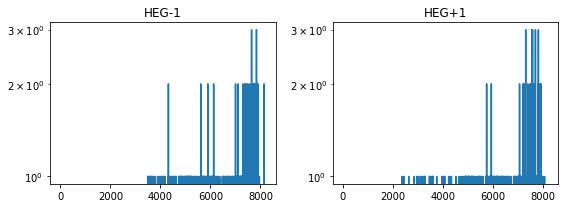

In [18]:
j=1
for i in range(len(spec_table)):
    matplotlib.rcParams['figure.figsize'] = (8, 3)
    if abs(spec_table['TG_M'][i]) == 1 and (spec_table['TG_PART'][i]) == 1:
        ax=plt.subplot(1,2,j)
        pha = plt.plot( spec_table['CHANNEL'][i],spec_table['COUNTS'][i])
        ax.set_yscale('log')
        if spec_table['TG_PART'][i] == 1:
            instr='HEG'
        ax.set_title("{grating}{order:+d}".format(grating=instr, order=spec_table['TG_M'][i]))
        plt.tight_layout()
        j=j+1


This can then be analyzed in your favorite spectral analysis tool, e.g., [pyXspec](https://heasarc.gsfc.nasa.gov/xanadu/xspec/python/html/index.html).  (For the winter 2018 AAS workshop, we demonstrated this in a [notebook](https://github.com/NASA-NAVO/aas_workshop_2018/blob/master/heasarc/heasarc_Spectral_Access.ipynb) that you can consult for how to use pyXspec, but the pyXspec documentation will have more information.) 

Congratulations! You have completed this notebook exercise.